## Needed Packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
%matplotlib inline

import os
import scipy
from scipy import signal
import matplotlib.image as mpimg
from collections import deque
import glob
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration 

In [36]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [37]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        print(fname)
        #cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
print("Done")

camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
Done


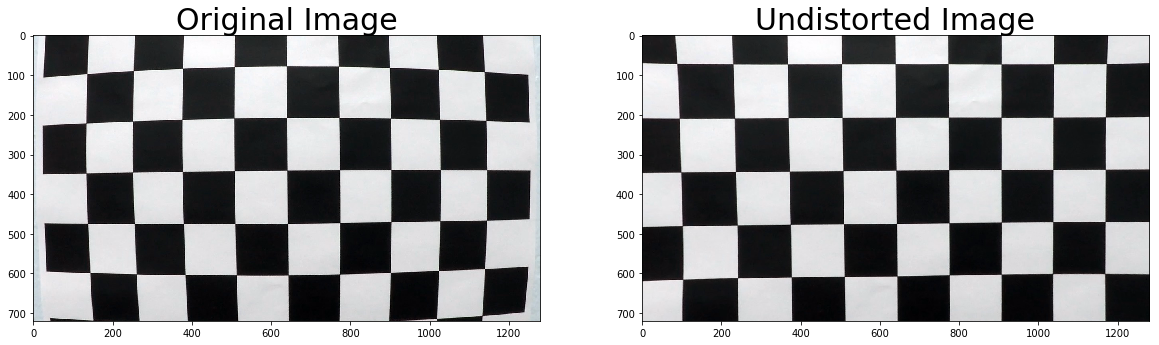

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)



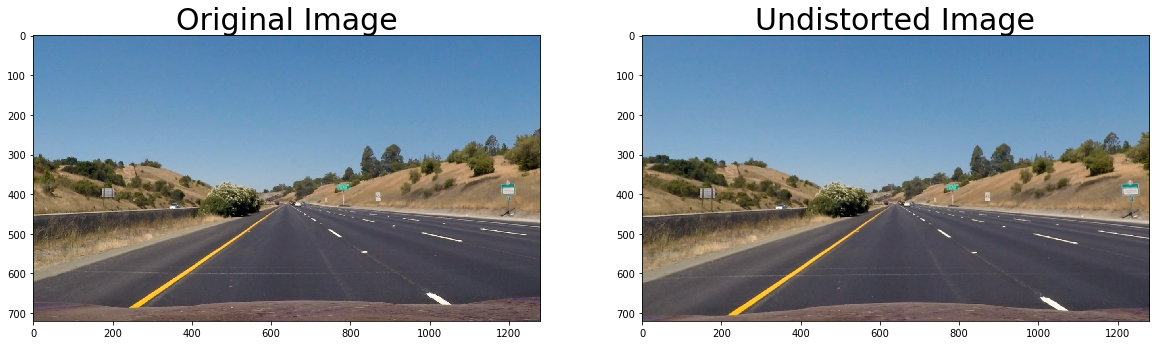

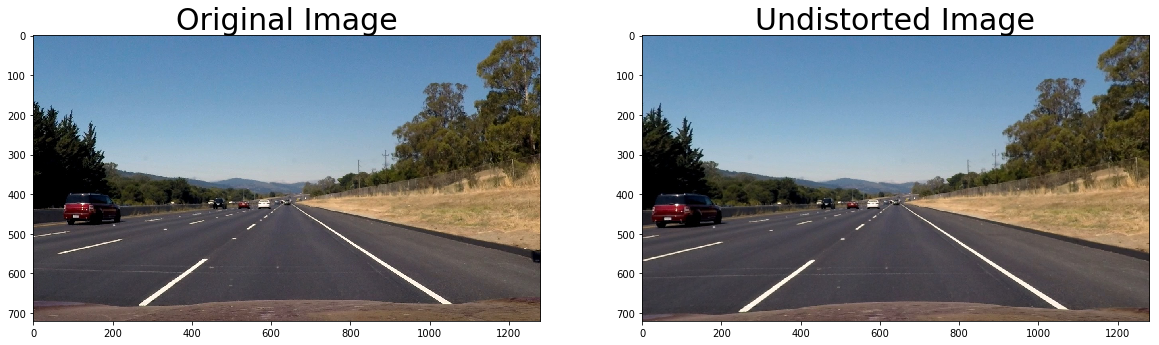

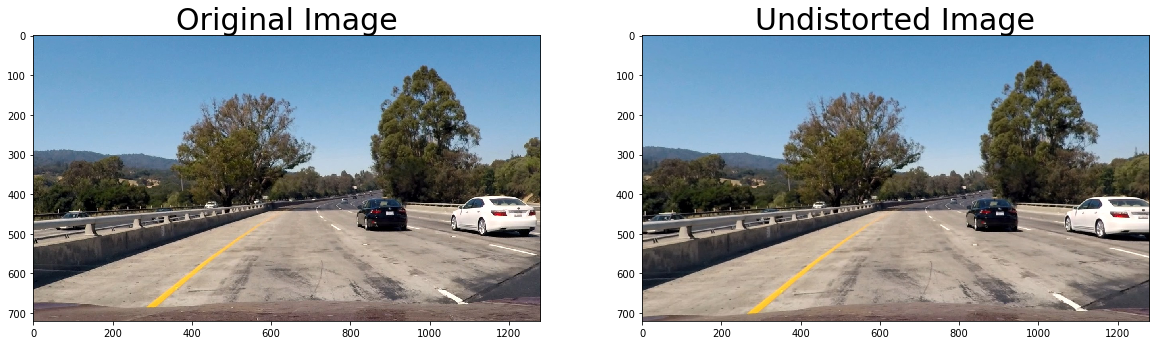

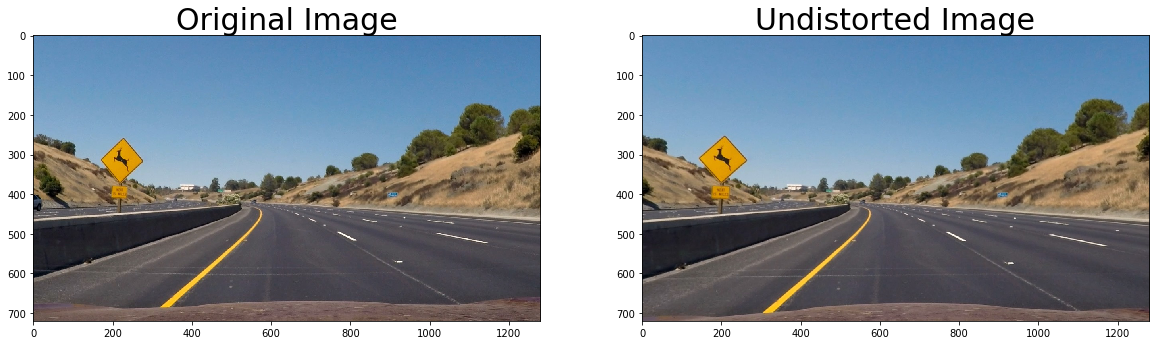

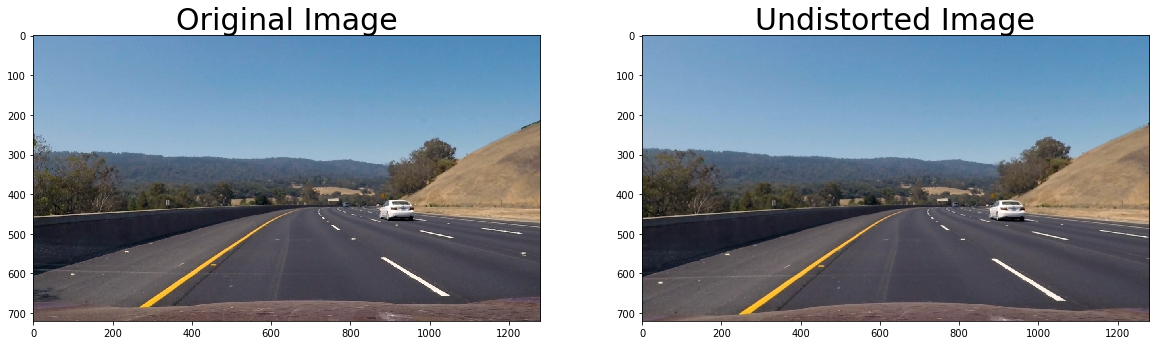

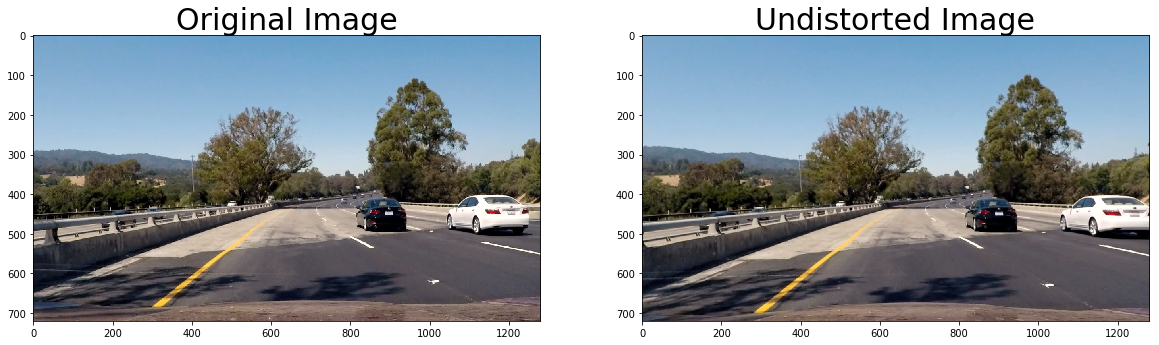

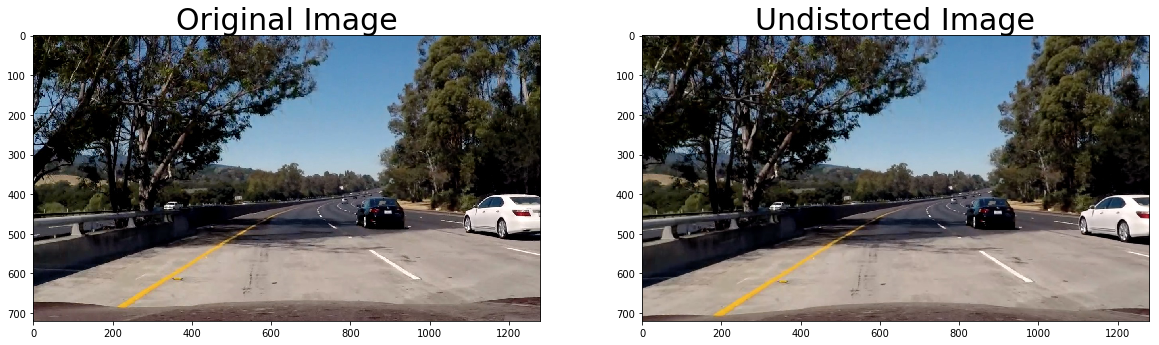

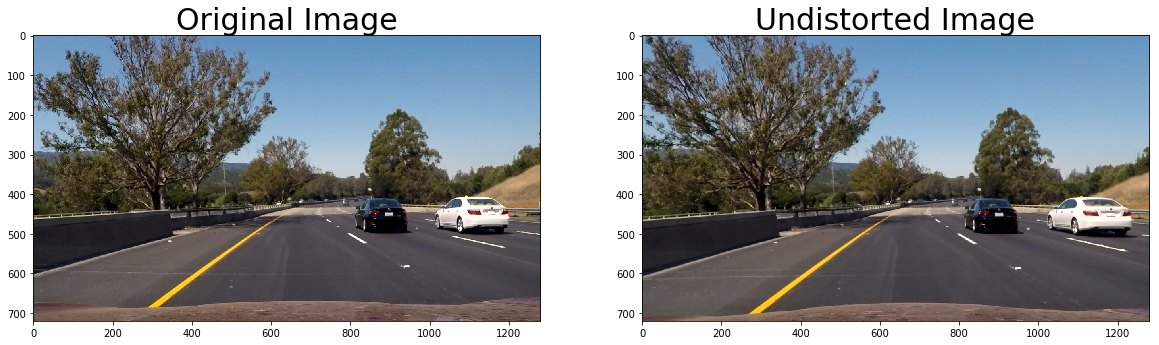

In [38]:
#Camera calibration with pickle on Testimages
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort(img)
    image_name=os.path.split(fname)[1]
    write_name = 'output_images/cal_test_images/'+image_name    
    cv2.imwrite(write_name,dst)
    #print(write_name)
    cv2.imshow('dst', dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=30)
    cv2.waitKey(500)
    
cv2.destroyAllWindows()

In [7]:
def undistort(img):
    with open('camera_cal/calibration.p', mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    return cv2.undistort(img, mtx, dist, None, mtx)


def top_view(img):
    img_size = (img.shape[1], img.shape[0])
    #Source	Destination
    #590, 450	320, 0
    #690, 450	960, 0
    #1120, 720	960, 720
    #190, 720	320, 720  
    
    src = np.float32([[590, img_size[1] - 270], [690, img_size[1] - 270], [1120, img_size[1]], [190, img_size[1]]])
    dst = np.float32([[(img_size[0] / 4), 0], [(img_size[0] * 3 / 4), 0], [(img_size[0] * 3 / 4), img_size[1]], [(img_size[0] / 4), img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    
    return warped, Minv


def hls_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    
    img = undistort(img)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary 


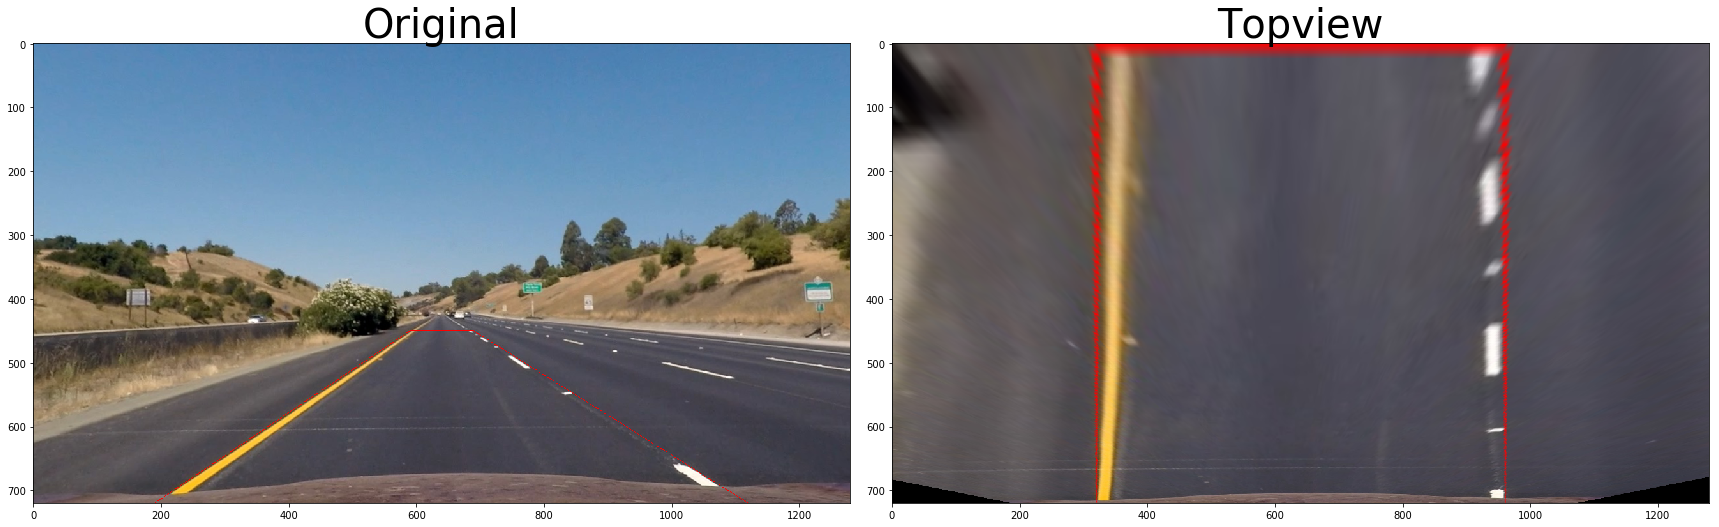

In [40]:
img = undistort(plt.imread('test_images/straight_lines1.jpg'))


img_size = (img.shape[1], img.shape[0])
#print(img_size)
corners = np.float32([[590, img_size[1] - 270], [690, img_size[1] - 270], [1120, img_size[1]], [190, img_size[1]]])
#print(corners)
corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)

warped, minv = top_view(img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Topview', fontsize=40)

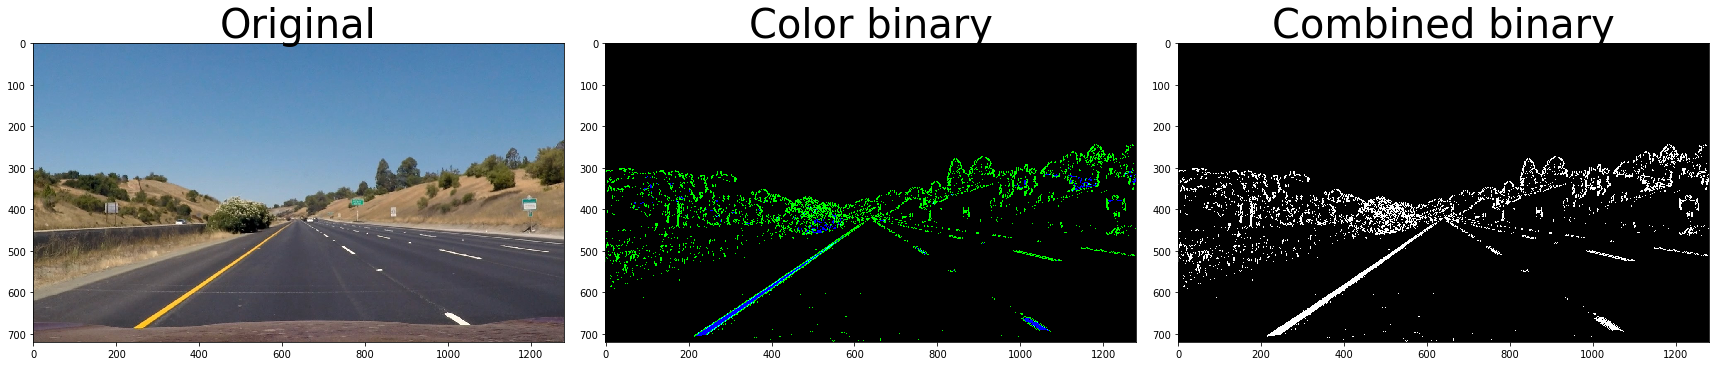

In [43]:
img= plt.imread('test_images/straight_lines1.jpg')

color_binary, combined_binary  = hls_pipeline(img)

# Plot the result
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color binary', fontsize=40)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined binary', fontsize=40)

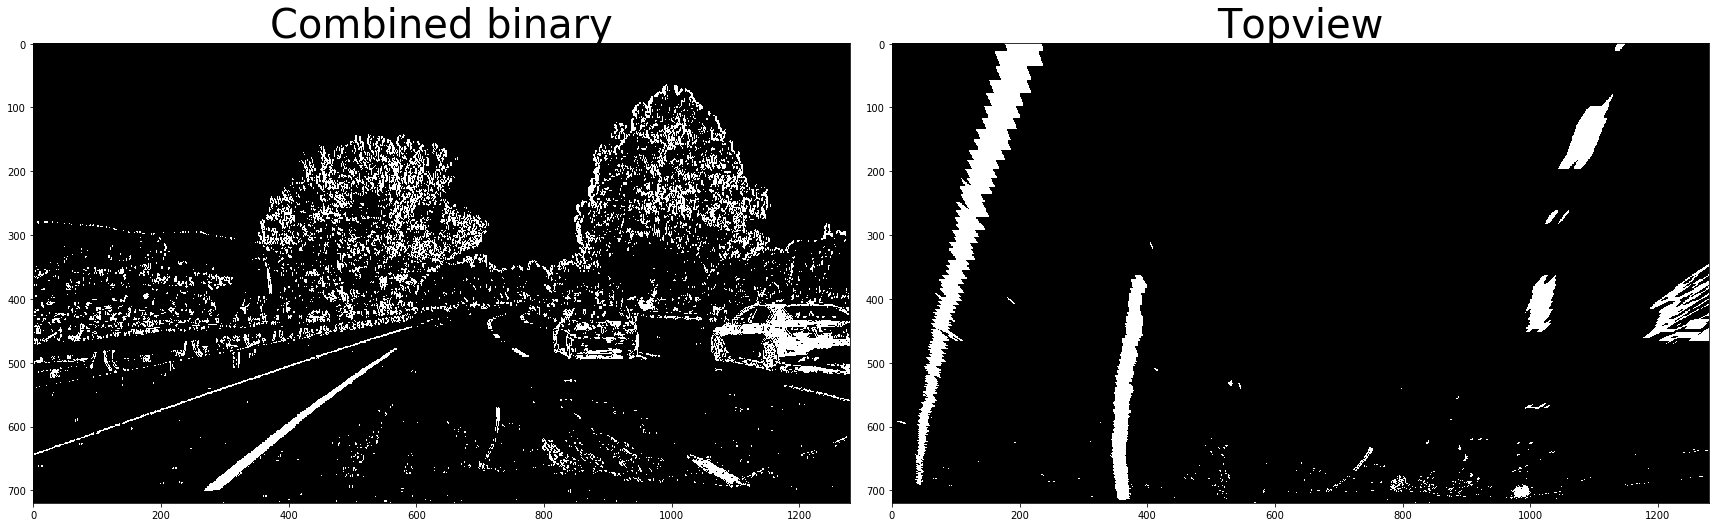

In [64]:
img= plt.imread('test_images/test1.jpg')

color_binary, combined_binary  = hls_pipeline(img)

top_view_binary, minv = top_view(combined_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined binary', fontsize=40)

ax2.imshow(top_view_binary, cmap='gray')
ax2.set_title('Topview', fontsize=40)


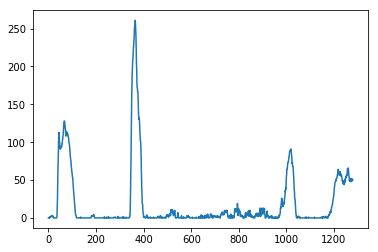

In [65]:
histogram = np.sum(top_view_binary[top_view_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [66]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

In [67]:
def find_lane(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 50
   
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculate Meters for write_on_image
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    #Visualize
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Draw
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty




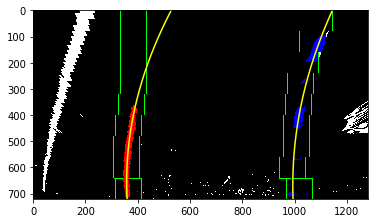

In [68]:
left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = find_lane(top_view_binary)

In [69]:
def better_find_lane(binary_warped, left_fit, right_fit):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    margin = 50

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # # Calculate Meters for write_on_image
    left_fit_m = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_m = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
        
    return left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty
 


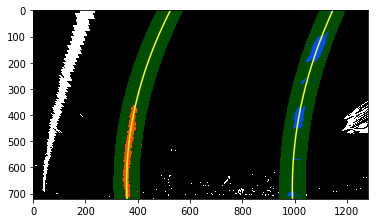

In [70]:
left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = better_find_lane(top_view_binary, left_fit, right_fit)

In [84]:
# Calculate the curve radius in real world in m
def calc_curve_rad_m(left_fit, right_fit, ploty):

    # Define y-value where we want radius of curvature (bottom of image)
    y_eval = np.max(ploty)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return round(left_curverad, 2), round(right_curverad, 2)

# Test curve radius calculation
left_curverad, right_curverad = calc_curve_rad_m(left_fit_m, right_fit_m, ploty)

print(left_curverad, 'm', right_curverad, 'm')

curvature = 0.5 * (right_curverad + left_curverad)

print(curvature)

427.11 m 490.8 m
458.955


In [85]:
# Calculate the distance between car and the lane center
def calc_offset(left_fit, right_fit, img_size):
    left_lane_x = left_fit[0] * img_size[0]**2 + left_fit[1] * img_size[0] + left_fit[2]
    right_lane_x = right_fit[0] * img_size[0]**2 + right_fit[1] * img_size[0] + right_fit[2]

    lane_center = (left_lane_x + right_lane_x) / 2.0

    return round((lane_center - img_size[0] / 2) * xm_per_pix, 2)


# Test offset calculation
print(' Distance from center: ', calc_offset(left_fit, right_fit, (img.shape[1], img.shape[0])), 'm')

 Distance from center:  0.89 m


In [106]:
def write_on_image(warped, left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty, Minv, image):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Add curvature and offset information
    left_curverad, right_curverad = calc_curve_rad_m(left_fit_m, right_fit_m, ploty)
    offset = calc_offset(left_fit, right_fit, (image.shape[1], image.shape[0]))
    text = 'Left: ' + str(left_curverad) + 'm, right: ' + str(right_curverad) + 'm. Curvature: ' + str(0.5 * (right_curverad + left_curverad)) + 'm' 
    text2 = 'Distance from center: ' + str(offset) + 'm'
    cv2.putText(result, text, (20, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(result, text2, (20, 100), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2, cv2.LINE_AA)
   
    return result                 

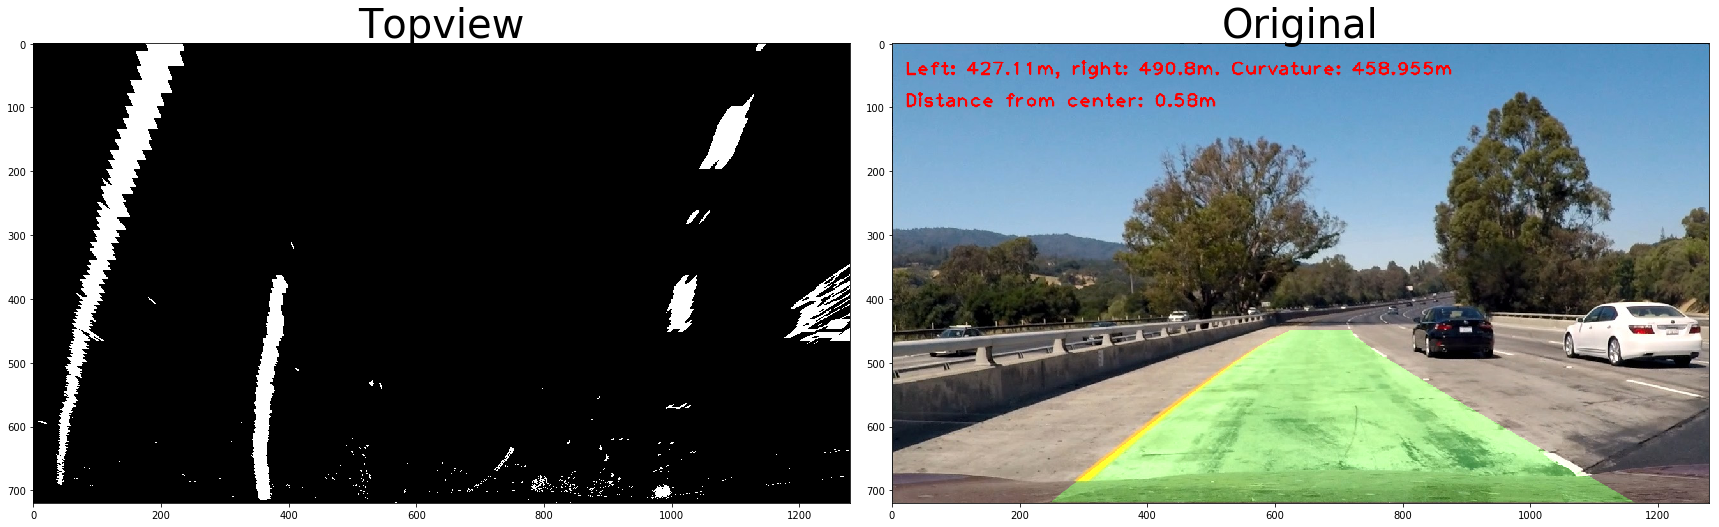

In [107]:
# Test image augmentation
result = write_on_image(top_view_binary, left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty, minv, img)


# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(top_view_binary, cmap='gray')
ax1.set_title('Topview', fontsize=40)

ax2.imshow(result)
ax2.set_title('Original', fontsize=40)


In [108]:
# Settings for smoothing
smoothing = True
smooth_buffer_size = 12

# Settings for sanity check
lane_width = 700
lane_width_deviation = 200
insane_patience = 5

In [118]:
# Check if lane lines are separated by reasonable distance
# (check performed at bottom and top, as well as in the middle of the image)
def sanity_check(left_fit, right_fit, height):
    a_l = left_fit[0] * height**2 + left_fit[1] * height + left_fit[2]
    b_l = left_fit[0] * (height / 2)**2 + left_fit[1] * (height / 2) + left_fit[2]
    c_l = left_fit[0] * 0**2 + left_fit[1] * 0 + left_fit[2]
    
    a_r = right_fit[0] * height**2 + right_fit[1] * height + right_fit[2]
    b_r = right_fit[0] * (height / 2)**2 + right_fit[1] * (height / 2) + right_fit[2]
    c_r =  right_fit[0] * 0**2 + right_fit[1] * 0 + right_fit[2]
    
    bot_dist_sane = lane_width - lane_width_deviation < (a_r - a_l) < lane_width + lane_width_deviation
    mid_dist_sane = lane_width - lane_width_deviation < (b_r - b_l) < lane_width + lane_width_deviation
    top_dist_sane = lane_width - lane_width_deviation < (c_r - c_l) < lane_width + lane_width_deviation
    
    return bot_dist_sane and mid_dist_sane and top_dist_sane

In [119]:
def pipeline(image):
    
    global left_fit
    global right_fit
    
    global left_fit_avg
    global right_fit_avg
    global left_fitx_avg
    global right_fitx_avg
    global ploty_avg
    
    global step
    global counter
    global rejection_counter
    global enough
    
    global insane_in_row
    global insane_patience
    
    counter += 1
    
    # 1. Process image to create a thresholded binary image where (ideally) only lane lines are visible in white
    rgb_undist, combined_binary = hls_pipeline(image)
    
    # 2. Warp image
    binary_warped, minv = top_view(combined_binary)
    
    # 3. Find lane lines in image and return their curves (use more advanced technique if there was a previous frame)
    # Also reset if too many frames in a row did not pass the sanity check
    if (left_fit is not None and right_fit is not None) and insane_in_row < insane_patience:
        left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = better_find_lane(binary_warped, left_fit, right_fit)
        
    else:
        left_fit_avg = np.empty(smooth_buffer_size, dtype=object)
        right_fit_avg = np.empty(smooth_buffer_size, dtype=object)
        left_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
        right_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
        ploty_avg = np.empty(smooth_buffer_size, dtype=object)
        enough = False
        step = 0
        insane_in_row = 0
        #Start with the Histogram method
        left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty = find_lane(binary_warped)
        
    # Sanity check if it fails start with the Histogram method 
    if sanity_check(left_fit, right_fit, image.shape[0]):
        left_fit_avg[step] = left_fit
        right_fit_avg[step] = right_fit
        left_fitx_avg[step] = left_fitx
        right_fitx_avg[step] = right_fitx
        ploty_avg[step] = ploty

        step += 1
    else:
        rejection_counter += 1
        insane_in_row += 1            
        
    if step >= smooth_buffer_size:
        enough = True
        step = 0
        
    # Smooth by averaging if enabled and enough frames captured
    if enough and smoothing:
        left_fit = np.mean(left_fit_avg)
        right_fit = np.mean(right_fit_avg)
        left_fitx = np.mean(left_fitx_avg)
        right_fitx = np.mean(right_fitx_avg)
        ploty = np.mean(ploty_avg)
        
    # 4. Augment image with lane and text overlays
    final = write_on_image(binary_warped, left_fit, right_fit, left_fitx, right_fitx, left_fit_m, right_fit_m, ploty, minv, image)
   
    return final

In [117]:
# Import everything needed to edit and save video clips
from moviepy.editor import VideoFileClip

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [03:41<00:00,  5.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 55s, sys: 55.3 s, total: 4min 50s
Wall time: 3min 42s
Total frames:  1261
Rejected:  56


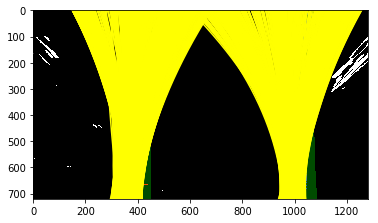

In [115]:
# Initialize variables
left_fit = None
right_fit = None

left_fit_avg = np.empty(smooth_buffer_size, dtype=object)
right_fit_avg = np.empty(smooth_buffer_size, dtype=object)
left_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
right_fitx_avg = np.empty(smooth_buffer_size, dtype=object)
ploty_avg = np.empty(smooth_buffer_size, dtype=object)

step = 0
counter = 0
rejection_counter = 0
enough = False
insane_in_row = 0

# Create output name string
output = 'output.mp4'

# Process video
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('project_video.mp4').subclip(18, 26)
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)
# Print some stats
print('Total frames: ', counter)
print('Rejected: ', rejection_counter)
